<a href="https://colab.research.google.com/github/PedroAMtz/Biomedical_Imaging/blob/main/Brain_MRI_Images_for_Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Brain MRI Images for Brain Tumor Detection**

Simple Keras models to observe regularization behavior

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os, os.path
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from zipfile import ZipFile
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Loading data from Kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 73 bytes


In [3]:
!kaggle datasets download -d jjprotube/brain-mri-images-for-brain-tumor-detection

 99% 15.0M/15.1M [00:00<00:00, 71.2MB/s]
100% 15.1M/15.1M [00:00<00:00, 65.6MB/s]


In [4]:
file_name = '/content/brain-mri-images-for-brain-tumor-detection.zip'
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Extraction done')

Extraction done


# Data Analysis

In [5]:
import os

# folder path
dir_paths = ['no', 'yes']
count = 0
# Iterate directory
for path in os.listdir(dir_paths[0]):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_paths[0], path)):
        count += 1
print('Number of {} labeled images:'.format(str(dir_paths[0])), count)

count=0

for path in os.listdir(dir_paths[1]):
  if os.path.isfile(os.path.join(dir_paths[1], path)):
      count += 1
print('Number of {} labeled images:'.format(str(dir_paths[1])), count)

Number of no labeled images: 98
Number of yes labeled images: 155


# Reading Image Data

In [12]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

def read_and_decode(filename, reshape_dims):
  # 1-> Read the file
  img = tf.io.read_file(filename)
  # 2-> Convert compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=1)
  # 3-> Convert 3D uint8 to floats in the range [0,1]
  img = tf.image.convert_image_dtype(img, tf.float32)
  # 4-> Resize the image
  return tf.image.resize(img, reshape_dims)

def show_image(label1, label2):
  img_label1 = read_and_decode('/content/brain_tumor_dataset/{}/3 {}.jpg'.format(str(label1), str(label1)), [IMG_HEIGHT, IMG_WIDTH])
  img_label2 = read_and_decode('/content/brain_tumor_dataset/{}/Y10.jpg'.format(str(label2), str(label2)), [IMG_HEIGHT, IMG_WIDTH])
  f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
  ax1.imshow(img_label1.numpy(), cmap='gray')
  ax1.set_title('Brain MRI image labeled as {}'.format(str(label1)))
  ax2.imshow(img_label2.numpy(), cmap='gray')
  ax2.set_title('Brain MRI image labeled as {}'.format(str(label2)))
  ax1.axis('off')
  ax2.axis('off')

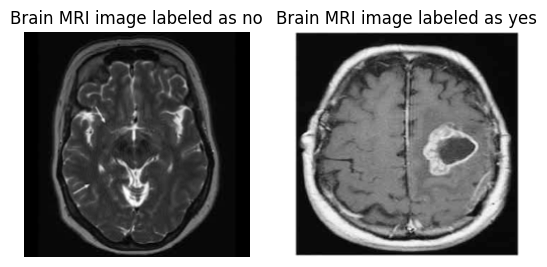

In [13]:
show_image('no', 'yes')

**Preparing data for training**

In [14]:
data = pd.DataFrame({'Filepath':os.listdir('/content/brain_tumor_dataset/yes') + os.listdir('/content/brain_tumor_dataset/no'),
                     'labels': ['yes'] * 155 + ['no'] * 98})
data

,Filepath,labels
0,Y247.JPG,yes
1,Y242.JPG,yes
2,Y102.jpg,yes
3,Y73.jpg,yes
4,Y106.jpg,yes
...,...,...
248,no 5.jpeg,no
249,no 98.jpg,no
250,no 923.jpg,no
251,no 90.jpg,no


In [15]:
from sklearn.model_selection import train_test_split
image_data = []
for i in range(len(data)):
  try:
    image = read_and_decode(str('/content/brain_tumor_dataset/yes/') + str(data['Filepath'][i]), [IMG_HEIGHT, IMG_WIDTH])
    image_data.append(image)
  except:
    image = read_and_decode(str('/content/brain_tumor_dataset/no/') + str(data['Filepath'][i]), [IMG_HEIGHT, IMG_WIDTH])
    image_data.append(image)

In [16]:
image_data = np.array(image_data)
image_data.shape

(253, 224, 224, 1)

In [17]:
labels = data['labels']

X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.20, random_state=42)
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape) 
print("y_test Shape: ", y_test.shape)

X_train Shape:  (202, 224, 224, 1)
X_test Shape:  (51, 224, 224, 1)
y_train Shape:  (202,)
y_test Shape:  (51,)


In [18]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [19]:
y_train[0]

array([0., 1.], dtype=float32)

# Keras Models

**LINEAR MODEL**

In [20]:
model_linear = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

model_linear.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics='accuracy')

In [21]:
model_linear.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 2)                 100354    
                                                                 
Total params: 100,354
Trainable params: 100,354
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model_linear.fit(X_train, y_train,
                           validation_split=0.2,
                           epochs=20)

Epoch 1/20
6/6 [==============================] - 1s 71ms/step - loss: 1.9848 - accuracy: 0.5714 - val_loss: 1.4778 - val_accuracy: 0.5854
Epoch 2/20
6/6 [==============================] - 0s 25ms/step - loss: 0.9649 - accuracy: 0.6770 - val_loss: 0.9307 - val_accuracy: 0.6098
Epoch 3/20
6/6 [==============================] - 0s 36ms/step - loss: 0.6760 - accuracy: 0.7453 - val_loss: 1.5390 - val_accuracy: 0.6829
Epoch 4/20
6/6 [==============================] - 0s 24ms/step - loss: 0.5653 - accuracy: 0.7578 - val_loss: 1.3350 - val_accuracy: 0.7073
Epoch 5/20
6/6 [==============================] - 0s 25ms/step - loss: 1.4170 - accuracy: 0.6770 - val_loss: 1.9299 - val_accuracy: 0.5610
Epoch 6/20
6/6 [==============================] - 0s 20ms/step - loss: 0.5437 - accuracy: 0.7764 - val_loss: 1.0844 - val_accuracy: 0.5854
Epoch 7/20
6/6 [==============================] - 0s 23ms/step - loss: 0.3644 - accuracy: 0.8323 - val_loss: 1.3838 - val_accuracy: 0.6829
Epoch 8/20
6/6 [===========

In [23]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(15,5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric])
        ax[idx].set_xlabel("Epochs")
        # ax[idx].set_ylabel(metric, fontweight='bold', fontsize=20)
        ax[idx].plot(history.history['val_' + metric], ls='dashed');
        ax[idx].legend([metric, 'val_' + metric], fontsize=10)

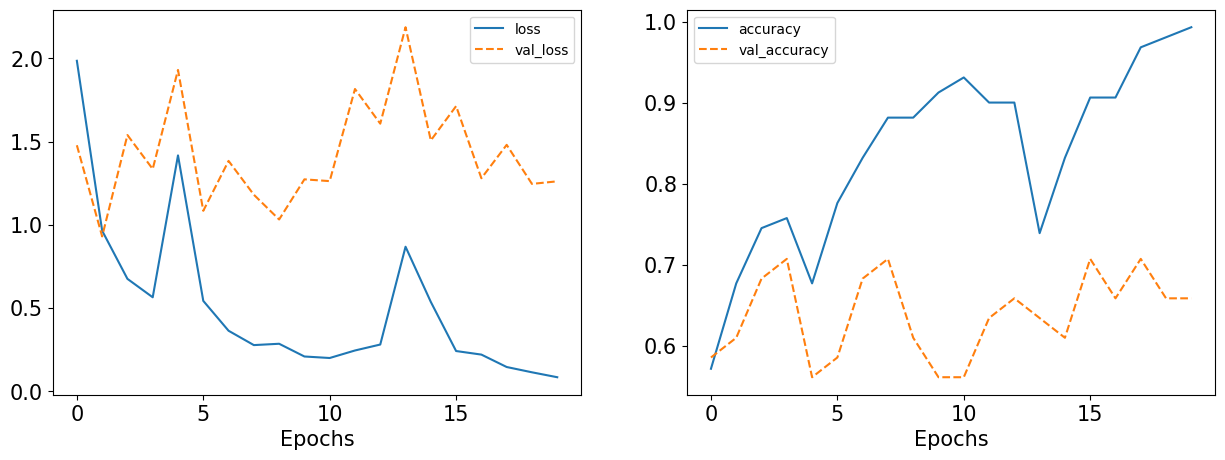

In [24]:
training_plot(['loss', 'accuracy'], history);

In [25]:
CLASS_NAMES = [item.numpy().decode("utf-8") for item in 
               tf.strings.regex_replace(
                 tf.io.gfile.glob("/content/brain_tumor_dataset/*"),
                 "/content/brain_tumor_dataset/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)


def plot_prediction(file_name, label_idx):
  img = read_and_decode(str('/content/brain_tumor_dataset/yes/') + str(file_name), [IMG_HEIGHT, IMG_WIDTH]) 
  batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, 1])
  batch_pred = model_linear.predict(batch_image);
  pred = batch_pred[0]
  label = CLASS_NAMES[label_idx]
  pred_label_index = tf.math.argmax(pred).numpy()
  pred_label = CLASS_NAMES[pred_label_index]
  prob = pred[pred_label_index]
  plt.imshow(img.numpy(), cmap='gray');
  plt.title('{} -> {} ({:.2f})'.format(label, pred_label, prob))
  plt.axis('off')

These are the available classes: ['no', 'yes']


1/1 [==============================] - 0s 112ms/step


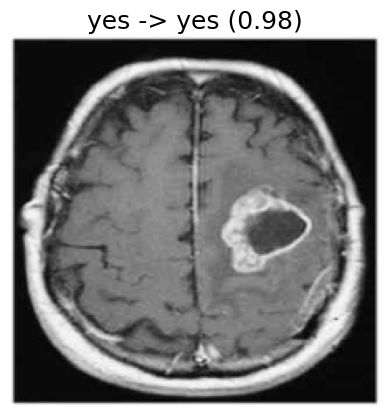

In [27]:
plot_prediction('Y10.jpg', 1)

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
accuracy = model_linear.evaluate(X_test, y_test)
print('Evaluation accuracy of:' , accuracy[1]*100,'%')

pred_y = (model_linear.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, pred_y))

2/2 [==============================] - 0s 17ms/step - loss: 0.5093 - accuracy: 0.7647
Evaluation accuracy of: 76.47058963775635 %
2/2 [==============================] - 0s 11ms/step
              precision    recall  f1-score   support

           0       0.93      0.58      0.72        24
           1       0.68      0.96      0.80        27

   micro avg       0.75      0.78      0.77        51
   macro avg       0.81      0.77      0.76        51
weighted avg       0.80      0.78      0.76        51
 samples avg       0.76      0.78      0.77        51



**Adding more layers and regularization**

In [31]:
regularizer = tf.keras.regularizers.l1_l2(0, 0.001)

model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    tf.keras.layers.Dense(128,
                          kernel_regularizer=regularizer,
                          activation='relu'),
    tf.keras.layers.Dense(2,
                          kernel_regularizer=regularizer,
                          activation='sigmoid')
])
model_reg.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics='accuracy')

In [32]:
model_reg.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 50176)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               6422656   
                                                                 
 dense_4 (Dense)             (None, 2)                 258       
                                                                 
Total params: 6,422,914
Trainable params: 6,422,914
Non-trainable params: 0
_________________________________________________________________


In [33]:
history_1 = model_reg.fit(X_train, y_train,
                           validation_split=0.2,
                           epochs=20)

Epoch 1/20
6/6 [==============================] - 3s 196ms/step - loss: 5.1748 - accuracy: 0.5652 - val_loss: 12.8545 - val_accuracy: 0.5854
Epoch 2/20
6/6 [==============================] - 1s 131ms/step - loss: 5.9992 - accuracy: 0.6522 - val_loss: 2.8246 - val_accuracy: 0.5366
Epoch 3/20
6/6 [==============================] - 1s 101ms/step - loss: 2.9091 - accuracy: 0.7143 - val_loss: 4.4113 - val_accuracy: 0.7073
Epoch 4/20
6/6 [==============================] - 1s 119ms/step - loss: 1.4586 - accuracy: 0.7764 - val_loss: 2.7740 - val_accuracy: 0.5610
Epoch 5/20
6/6 [==============================] - 1s 130ms/step - loss: 1.7557 - accuracy: 0.7205 - val_loss: 3.1679 - val_accuracy: 0.7073
Epoch 6/20
6/6 [==============================] - 1s 124ms/step - loss: 1.1126 - accuracy: 0.7826 - val_loss: 1.9834 - val_accuracy: 0.7317
Epoch 7/20
6/6 [==============================] - 1s 100ms/step - loss: 0.6838 - accuracy: 0.8758 - val_loss: 2.3393 - val_accuracy: 0.7317
Epoch 8/20
6/6 [===

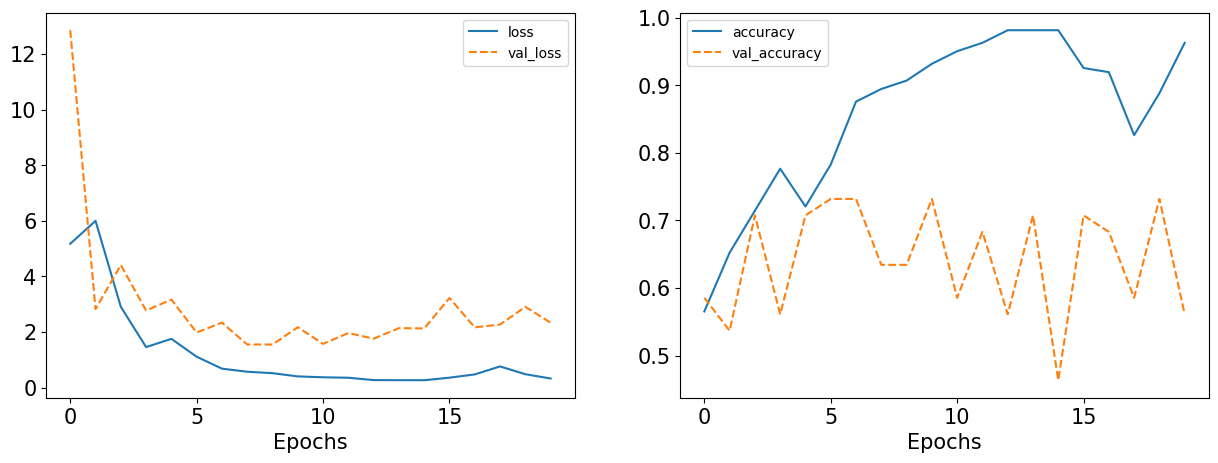

In [34]:
training_plot(['loss', 'accuracy'], history_1);

In [35]:
accuracy = model_reg.evaluate(X_test, y_test)
print('Evaluation accuracy of:' , accuracy[1]*100,'%')

pred_y = (model_reg.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, pred_y))

2/2 [==============================] - 0s 26ms/step - loss: 1.3076 - accuracy: 0.7059
Evaluation accuracy of: 70.58823704719543 %
2/2 [==============================] - 0s 23ms/step
              precision    recall  f1-score   support

           0       0.68      0.71      0.69        24
           1       0.78      0.67      0.72        27

   micro avg       0.73      0.69      0.71        51
   macro avg       0.73      0.69      0.71        51
weighted avg       0.73      0.69      0.71        51
 samples avg       0.69      0.69      0.69        51



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
